## This is a descriptive analysis to verify the current state of the elections of 2022 in toulouse for participatory budget

This notebook is based on the output of another notebook that was created by Juan Ignacio

#### Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ydata_profiling import ProfileReport


#### Loading the datasources

In [2]:
aggregatedProjectsDF = pd.read_csv('projectsAgg2.csv',sep=";")
electionDetailsDF = pd.read_csv('projectDetails.csv', sep=";")
xlsx = pd.ExcelFile('/home/samuel-malaga/Documents/Master2IS/Stage M1/M2IS-Internship-XAI/PBToulouse2022/Copie de Resultats BP31102022-.xlsx')
electionResultsDF = pd.read_excel(xlsx,'lauréats')
##Drop the last summary row in the dataframe
electionResultsDF.drop(electionResultsDF.tail(1).index,inplace=True)

print("Election aggregated projects", aggregatedProjectsDF.columns,"\n")
print("Election details",electionDetailsDF.columns,"\n")
print("Election results", electionResultsDF.columns,"\n")

Election aggregated projects Index(['project_id', 'project_name', 'description', 'category', 'cost',
       'district', 'votes'],
      dtype='object') 

Election details Index(['ID', 'project_id', 'project_title', 'created_at', 'checked_out_at',
       'project_url', 'vote_finished'],
      dtype='object') 

Election results Index(['Quartier', 'Catégorie', 'Titre de l'idée', 'Montant', 'VOIX',
       'Total par quartier', 'Hypothèse \nRepêchage', 'Nb projets'],
      dtype='object') 



In [3]:
electionDetailsDF['created_at'] = pd.to_datetime(electionDetailsDF['created_at'])
electionDetailsDF['checked_out_at'] = pd.to_datetime(electionDetailsDF['checked_out_at'])
electionDetailsDF['session_duration'] = electionDetailsDF['checked_out_at'] - electionDetailsDF['created_at']
aggregatedProjectsDF['title_length'] = aggregatedProjectsDF['project_name'].str.len()
aggregatedProjectsDF['description_length'] = aggregatedProjectsDF['description'].str.len()

#### Performing some cleaning and mapping before analyzing

In [4]:
##Unique districts from the aggregated projects
print(aggregatedProjectsDF['district'].unique())
print(len(aggregatedProjectsDF['district'].unique()))

##Separating district number from the district description
## add_district_code stands for district code from the aggregated values (most likely the data that was scraped had different codes than the
## source data)
aggregatedProjectsDF[['agg_district_code', 'agg_quartiers']] = aggregatedProjectsDF['district'].str.extract(r'^(\d+)\s*-\s*(.+)$')
aggregatedProjectsDF['agg_district_code'] = aggregatedProjectsDF['agg_district_code'].astype(int)
print(aggregatedProjectsDF['agg_district_code'].unique())
print(len(aggregatedProjectsDF['agg_district_code'].unique()))


['12 - Pont des Demoiselles / Ormeau / Montaudran / La Terrasse / Malepère'
 '8 - Minimes / Barrière de Paris / Ponts-Jumeaux / La Vache / Raisins / Fondeyre'
 "11 - Bonhoure / Guilheméry / Château de l'Hers / Limayrac / Côte Pavée"
 '5 - Saint-Michel / Saint-Agne / Empalot / Le Busca / Ile du Ramier / Monplaisir'
 '7 - Sept Deniers / Ginestous-Sesquières / Lalande'
 "15 - Croix de Pierre / Route d'Espagne"
 '17 - Mirail-Université / Reynerie / Bellefontaine'
 '9 - Trois Cocus / Borderouge / Croix-Daurade / Paléficat / Grand Selve'
 '4 - Lapujade / Bonnefoy / Périole / Marengo / La Colonne'
 '18 - Lardenne / Pradettes / Basso-Cambo'
 '20 - Arènes Romaines / Ancely / Saint-Martin du Touch / Purpan'
 '1 - Capitole / Arnaud Bernard / Carmes'
 '13 - Rangueil / Sauzelong / Jules-Julien / Pech-David / Pouvourville'
 '14 - Saint-Simon / Lafourguette / Oncopole-Campus Santé du Futur'
 '6 - Saint-Cyprien'
 '16 - Fontaine-Lestang / Arènes / Bagatelle / Papus / Tabar / Bordelongue / Mermoz / La F

In [5]:
##Unique districts from the election results
print(electionResultsDF['Quartier'].unique())
print(len(electionResultsDF['Quartier'].unique()))

##Separating the district number from the district description
## src_district_code stand for source district code and it refers to the distric codes that were inputted in the dataset from 2022
electionResultsDF[['src_district_code','src_quartiers']] = electionResultsDF['Quartier'].str.extract(r'([0-9]+\.[0-9]+)\s*-\s*(.*)')
print(electionResultsDF['src_district_code'].unique())
print(len(electionResultsDF['src_district_code'].unique()))

['1.1 - Capitole / Arnaud Bernard / Carmes'
 '1.2 - Amidonniers / Compans-Caffarelli'
 '1.3 - Les Chalets / Bayard / Belfort / Saint Aubin / Dupuy'
 '2.1 - Saint-Cyprien' "2.2 - Croix-de-Pierre / Route d'Espagne"
 '2.3 - Fontaine-Lestang / Arènes / Bagatelle / Papus / Tabar / Bordelongue / Mermoz / La Faourette'
 '2.4 - Casselardit / Fontaine-Bayonne / Cartoucherie'
 '3.1 - Minimes / Barrière de Paris / Ponts-Jumeaux'
 '3.2 - Sept-Deniers / Ginestous / Lalande'
 '3.3 - Trois Cocus / Borderouge / Croix Daurade / Paléficat / Grand Selve'
 '4.1 - Lapujade / Bonnefoy / Périole / Marengo / La Colonne'
 '4.2 - Jolimont / Soupetard / Roseraie / Gloire / Gramont / Amouroux'
 "4.3 - Bonhoure / Guilheméry / Château de l'Hers / Limayrac / Côte Pavée"
 '5.1 - Pont des Demoiselles / Ormeau / Montaudran / La Terrasse / Malepère'
 '5.2 - Rangueil / Sauzelong / Pech-David / Pouvourville'
 '5.3 - Saint-Michel / Le Busca / Empalot / Saint-Agne / Ile du Ramier'
 '6.1 - Arènes Romaines / Saint-Martin-du-T

In [6]:
##Preparation to merge the district codes from the source to the aggregated dataset
district_mapping = {
    1: '1.1', 2: '1.2', 3: '1.3', 4: '4.1', 5: '5.3', 6: '2.1', 
    7: '3.2', 8: '3.1', 9: '3.3', 10: '4.2', 11: '4.3', 12: '5.1', 
    13: '5.2', 14: '6.4', 15: '2.2', 16: '2.3', 17: '6.3', 18: '6.2', 
    19: '2.4', 20: '6.1'
}

aggregatedProjectsDF['src_district_code'] = aggregatedProjectsDF['agg_district_code'].map(district_mapping)

print(aggregatedProjectsDF[['src_district_code','agg_district_code']].drop_duplicates())


   src_district_code  agg_district_code
0                5.1                 12
1                3.1                  8
2                4.3                 11
3                5.3                  5
6                3.2                  7
7                2.2                 15
8                6.3                 17
9                3.3                  9
13               4.1                  4
15               6.2                 18
18               6.1                 20
21               1.1                  1
22               5.2                 13
26               6.4                 14
27               2.1                  6
32               2.3                 16
35               1.3                  3
38               1.2                  2
42               2.4                 19
51               4.2                 10


In [7]:
# Create a set of tuples from 'Titre de l'idée' and 'src_district_code' columns in electionResultsDF
election_results_tuples = set(zip(electionResultsDF['Titre de l\'idée'], electionResultsDF['src_district_code']))

# Create the 'approved' column by checking if the combination of 'project_name' and 'src_district_code' exists in the set
aggregatedProjectsDF['approved'] = aggregatedProjectsDF.apply(
    lambda row: (row['project_name'], row['src_district_code']) in election_results_tuples, axis=1
)

aggregatedProjectsDF['approved_binary'] = aggregatedProjectsDF['approved'].astype(int)

In [8]:
print(aggregatedProjectsDF.columns)
# aggregatedProjectsDF.to_csv("projectsAggWResults.csv")

Index(['project_id', 'project_name', 'description', 'category', 'cost',
       'district', 'votes', 'title_length', 'description_length',
       'agg_district_code', 'agg_quartiers', 'src_district_code', 'approved',
       'approved_binary'],
      dtype='object')


### Exploratory analysis
The following questions are going to be the base for the analysis and then we can improve from that

**Total number of projects**

In [9]:
print(len(aggregatedProjectsDF))

199


**Total number of voters**

In [10]:
print(len(electionDetailsDF["ID"].unique()))

4532


**Count of voters per project**

In [11]:
print(aggregatedProjectsDF[['project_id','votes','approved_binary']].sort_values('votes', ascending=False))

     project_id  votes  approved_binary
62          136    492                1
50            7    467                1
23            5    358                1
0           132    258                1
100          71    243                1
..          ...    ...              ...
8           181      2                0
20           50      2                0
79          187      2                0
157         176      2                0
148         178      2                0

[199 rows x 3 columns]


**What are the avaliable categories of projects?**

In [12]:
print(aggregatedProjectsDF['category'].unique())

['Nature en ville' 'Cadre de vie' 'Éco-mobilité'
 'Consommation responsable' 'Énergie' 'Déchets et Recyclage']


**Frequency distribution of the voters**  
How many voters voted only for one project, two projects and three projects

In [13]:
voters_project_count = electionDetailsDF.groupby('ID')['project_title'].nunique()
print(voters_project_count.value_counts().sort_index())

project_title
1     872
2     250
3    3410
Name: count, dtype: int64


**How many projects were proposed per district**  

In [14]:
projects_per_district = aggregatedProjectsDF.groupby('agg_district_code')['project_name'].nunique()
print(projects_per_district)

agg_district_code
1     10
2     10
3     10
4     10
5     10
6     10
7     10
8     10
9      9
10    10
11    10
12    10
13    10
14    10
15    10
16    10
17    10
18    10
19    10
20    10
Name: project_name, dtype: int64


**Votes per district and number of approved projects**  

In [15]:
votes_per_district = aggregatedProjectsDF.groupby('agg_district_code')['votes'].sum()
winning_projects = aggregatedProjectsDF.loc[aggregatedProjectsDF.approved].groupby('agg_district_code').size()

result = pd.DataFrame({
    'total_votes': votes_per_district,
    'winning_projects_per_district': winning_projects
}).fillna(0).astype(int)

#votes_per_district_sorted = votes_per_district.sort_values(ascending=False)
print(result)

                   total_votes  winning_projects_per_district
agg_district_code                                            
1                         1369                              6
2                          582                              3
3                          524                              3
4                          410                              8
5                          768                              5
6                          778                              4
7                          308                              4
8                          752                              4
9                          329                              7
10                         714                              4
11                         436                              3
12                        1169                              4
13                         557                              4
14                         404                              4
15      

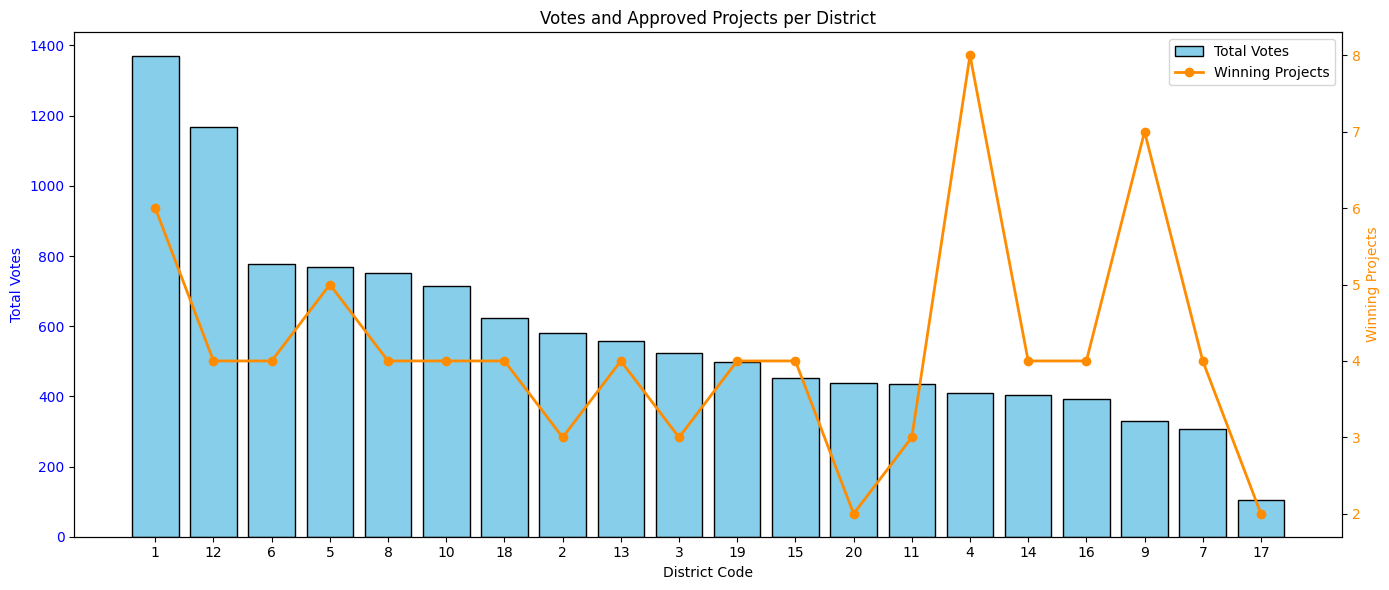

In [16]:
# Sort by total_votes for better readability
result_sorted = result.sort_values('total_votes', ascending=False)

# Set up figure
fig, ax1 = plt.subplots(figsize=(14, 6))

# Bar chart for total votes
bars = ax1.bar(result_sorted.index.astype(str), result_sorted['total_votes'], color='skyblue', edgecolor='black', label='Total Votes')
ax1.set_xlabel('District Code')
ax1.set_ylabel('Total Votes', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Second y-axis for winning projects
ax2 = ax1.twinx()
ax2.plot(result_sorted.index.astype(str), result_sorted['winning_projects_per_district'], color='darkorange', marker='o', linewidth=2, label='Winning Projects')
ax2.set_ylabel('Winning Projects', color='darkorange')
ax2.tick_params(axis='y', labelcolor='darkorange')

# Titles and layout
plt.title('Votes and Approved Projects per District')
fig.tight_layout()

# Optional: add legend
lines_labels = [ax.get_legend_handles_labels() for ax in [ax1, ax2]]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
ax1.legend(lines, labels, loc='upper right')

plt.show()

**Votes per category**  

In [17]:
votes_per_category = aggregatedProjectsDF.groupby('category')['votes'].sum()
votes_per_category_sorted = votes_per_category.sort_values(ascending=False)
print(votes_per_category_sorted)

category
Nature en ville             5936
Éco-mobilité                2562
Cadre de vie                2281
Énergie                      531
Déchets et Recyclage         235
Consommation responsable      61
Name: votes, dtype: int64


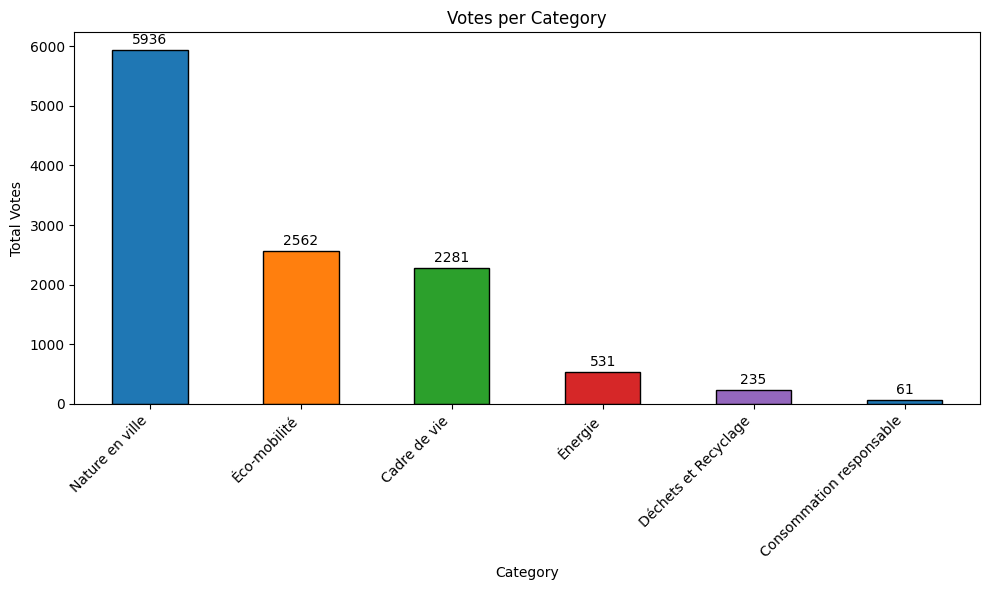

In [18]:
# Define a color for each category (must match the number of bars)
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']  # Example: blue, orange, green, red, purple

# Set figure size
plt.figure(figsize=(10, 6))

# Plot the bar chart with custom colors
ax = votes_per_category_sorted.plot(kind='bar', color=colors, edgecolor='black')

# Customize the plot
plt.title('Votes per Category')
plt.xlabel('Category')
plt.ylabel('Total Votes')
plt.xticks(rotation=45, ha='right')

# Add value labels
for i, value in enumerate(votes_per_category_sorted):
    ax.text(i, value + 50, str(value), ha='center', va='bottom')

plt.tight_layout()
plt.show()

**Number of voter per category of winning project**  

In [19]:
approvedProjects = aggregatedProjectsDF.loc[aggregatedProjectsDF.approved]
votes_per_category_winner = approvedProjects.groupby('category')['votes'].sum()
votes_per_category_winner = votes_per_category_winner.sort_values(ascending=False)
print(votes_per_category_winner)

category
Nature en ville         4914
Éco-mobilité            1951
Cadre de vie            1087
Énergie                  442
Déchets et Recyclage     171
Name: votes, dtype: int64


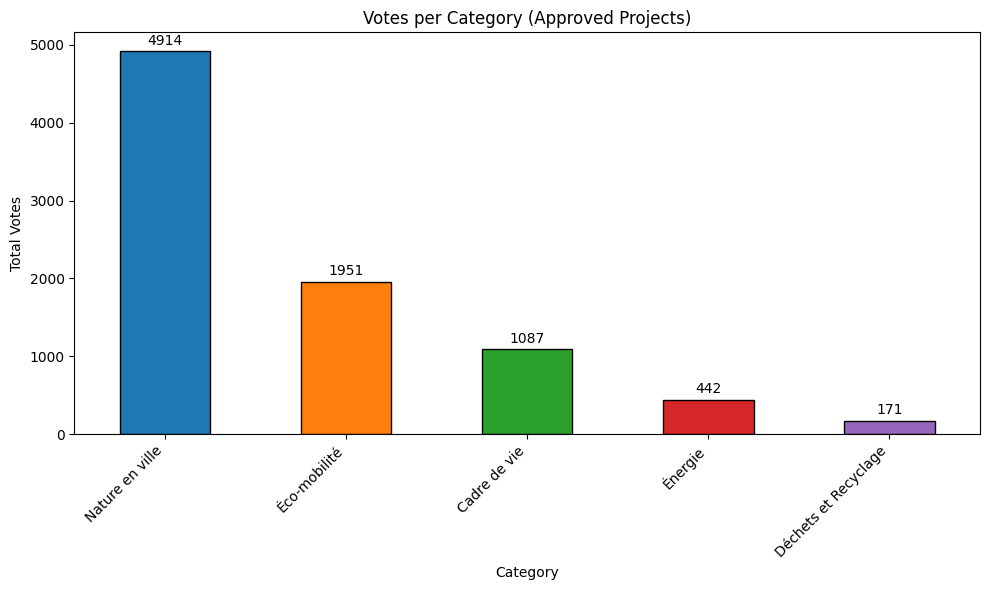

In [20]:
# Full set of categories and fixed colors
category_colors = {
    'Nature en ville': '#1f77b4',
    'Éco-mobilité': '#ff7f0e',
    'Cadre de vie': '#2ca02c',
    'Énergie': '#d62728',
    'Déchets et Recyclage': '#9467bd'
}

# Filtered data: only approved projects
approvedProjects = aggregatedProjectsDF.loc[aggregatedProjectsDF.approved]
votes_per_category_winner = approvedProjects.groupby('category')['votes'].sum()
votes_per_category_winner = votes_per_category_winner.sort_values(ascending=False)

# Get colors in correct order for the current plot
colors = [category_colors[cat] for cat in votes_per_category_winner.index]

# Plot
plt.figure(figsize=(10, 6))
ax = votes_per_category_winner.plot(kind='bar', color=colors, edgecolor='black')

# Customize
plt.title('Votes per Category (Approved Projects)')
plt.xlabel('Category')
plt.ylabel('Total Votes')
plt.xticks(rotation=45, ha='right')

# Add value labels
for i, value in enumerate(votes_per_category_winner):
    ax.text(i, value + 50, str(value), ha='center', va='bottom')

plt.tight_layout()
plt.show()

**Max project budget**  

In [21]:
print(aggregatedProjectsDF['cost'].max())

200000.0


**Min project budget**  

In [22]:
print(aggregatedProjectsDF['cost'].min())

1200.0


**Mean project budget**  

In [23]:
print(aggregatedProjectsDF['cost'].mean())

79586.53266331658


**Min session time**  
The duration of a voting process, the timediff between the checked out time and the vote finished time

In [24]:
print(electionDetailsDF['session_duration'].min())

0 days 00:00:02.102000


**Max session time**

In [25]:
print(electionDetailsDF['session_duration'].max())

23 days 05:08:02.164000


**Mean session time**

In [26]:
print(electionDetailsDF['session_duration'].mean())

0 days 04:39:04.790282612


**How well the title lenght correlates to the approval of the project**  

In [27]:
correlation_title = aggregatedProjectsDF['title_length'].corr(aggregatedProjectsDF['approved_binary'])
print(f"Correlation between title length and approval: {correlation_title}")

Correlation between title length and approval: 0.12025577226355394


**How well the description lenght correlates to the approval of the project**  

In [28]:
correlation_description = aggregatedProjectsDF['description_length'].corr(aggregatedProjectsDF['approved_binary'])
print(f"Correlation between title length and approval: {correlation_description}")

Correlation between title length and approval: 0.19023653907295024


**Project Approval by budget**  

In [29]:
budget_bins = [0,50000,100000, 150000, 200000]
budget_labels = ['0-50k', '50k-100k', '100k-150k', '150k-200k']

aggregatedProjectsDF['cost_range'] = pd.cut(aggregatedProjectsDF['cost'], bins=budget_bins, labels = budget_labels, right=True)

result = aggregatedProjectsDF.groupby(['cost_range', 'approved']).size().unstack()

result.columns = ['Not Approved', 'Approved'] if False in result.columns else ['Approved', 'Not Approved']

result['Total'] = result['Not Approved'] + result['Approved']

result['% Approved'] = ((result['Approved'] / result['Total']) * 100).round(2)
result['% Not Approved'] = ((result['Not Approved'] / result['Total']) * 100).round(2)

print(result[['% Approved','% Not Approved','Total']])

            % Approved  % Not Approved  Total
cost_range                                   
0-50k            35.79           64.21     95
50k-100k         33.33           66.67     45
100k-150k        36.36           63.64     22
150k-200k        70.27           29.73     37


/tmp/ipykernel_8978/2491333920.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  result = aggregatedProjectsDF.groupby(['cost_range', 'approved']).size().unstack()


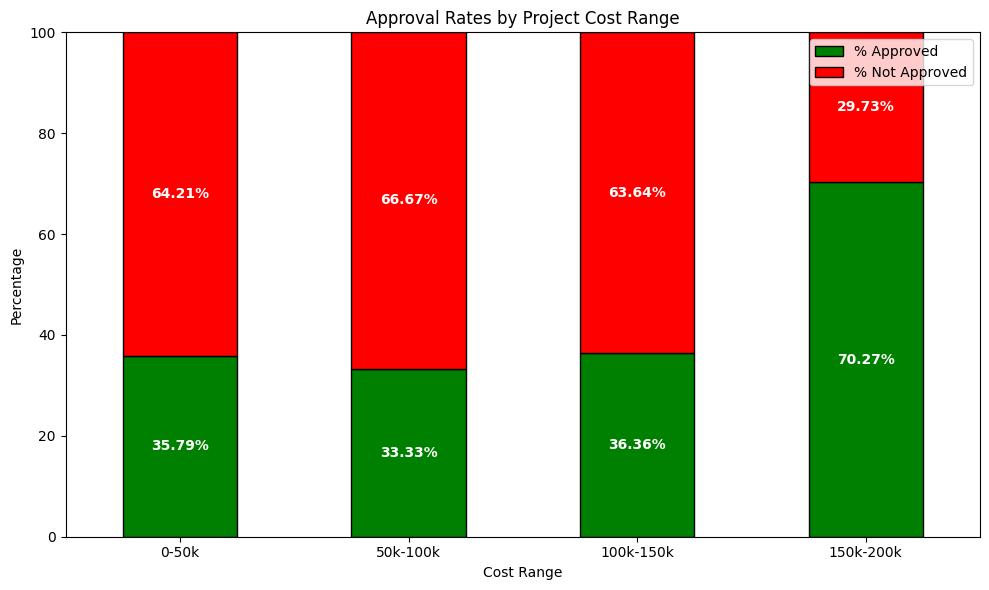

In [30]:
# Reuse your result table, use only % columns
percent_data = result[['% Approved', '% Not Approved']]

# Plot
ax = percent_data.plot(
    kind='bar',
    stacked=True,
    color=['green', 'red'],
    figsize=(10, 6),
    edgecolor='black'
)

# Customize
plt.title('Approval Rates by Project Cost Range')
plt.xlabel('Cost Range')
plt.ylabel('Percentage')
plt.xticks(rotation=0)
plt.ylim(0, 100)
plt.legend(loc='upper right')
plt.tight_layout()

# Add value labels inside the bars
for i, (approved, not_approved) in enumerate(zip(percent_data['% Approved'], percent_data['% Not Approved'])):
    ax.text(i, approved / 2, f'{approved}%', ha='center', va='center', color='white', fontweight='bold')
    ax.text(i, approved + not_approved / 2, f'{not_approved}%', ha='center', va='center', color='white', fontweight='bold')

plt.show()

**Automated EDA for the aggregated dataframe**

In [36]:
reportDataframe = aggregatedProjectsDF.copy(deep=True)
reportDataframe = reportDataframe.drop(columns=['agg_district_code', 'agg_quartiers','approved_binary', 'cost_range', 'project_id','src_district_code'])
profile = ProfileReport(reportDataframe,title="EDA aggregated")
profile.to_file("Report.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 264.03it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [32]:
# detailsDataFrame = electionDetailsDF.copy(deep=True)
# mergingDataFrame = aggregatedProjectsDF[['project_id','approved']]
# mergedDataframe = pd.merge(detailsDataFrame,mergingDataFrame, on="project_id")
# mergedDataframe['session_duration_hours'] = (mergedDataframe['session_duration'].dt.total_seconds()/3600).astype(int)
# print(mergedDataframe.columns)
# mergedDataframe = mergedDataframe.drop(columns=['checked_out_at', 'created_at','vote_finished', 'project_url','session_duration'])
# #mergedDataframe.dtypes
# details_profile = ProfileReport(mergedDataframe,title="EDA details")
# details_profile.to_file("Details Report.html")

In [33]:
winners_analysis = aggregatedProjectsDF[['project_id','votes','approved_binary','cost','src_district_code','project_name']].sort_values('votes', ascending=False).copy()
filtered_df = winners_analysis[winners_analysis['approved_binary'] == 1]
print(filtered_df[filtered_df['votes'] > 20].head())
# filtered_df.to_csv('text.csv')


     project_id  votes  approved_binary      cost src_district_code  \
62          136    492                1  200000.0               5.1   
50            7    467                1  150000.0               1.1   
23            5    358                1  200000.0               1.1   
0           132    258                1    7500.0               5.1   
100          71    243                1   20000.0               3.1   

                                          project_name  
62                 Piste cyclable avenue Saint-Exupéry  
50   Faire des voies vélos et piétons dédiées et bi...  
23              Végétalisation de la place du Capitole  
0                                Lutte anti-moustiques  
100  Planter des arbres et jardins partagés partout...  


In [34]:
merged_df = pd.merge(electionDetailsDF, aggregatedProjectsDF, on='project_id')
# merged_df.to_csv('mergedElectionData.csv')
test = merged_df[merged_df['project_id']==143]
print(test)

      ID  project_id                                      project_title  \
0     42         143  Lampadaires à détecteur de mouvement piste cyc...   
1     36         143  Lampadaires à détecteur de mouvement piste cyc...   
2     61         143  Lampadaires à détecteur de mouvement piste cyc...   
3     54         143  Lampadaires à détecteur de mouvement piste cyc...   
4     96         143  Lampadaires à détecteur de mouvement piste cyc...   
5    117         143  Lampadaires à détecteur de mouvement piste cyc...   
6    275         143  Lampadaires à détecteur de mouvement piste cyc...   
7    680         143  Lampadaires à détecteur de mouvement piste cyc...   
8   1010         143  Lampadaires à détecteur de mouvement piste cyc...   
9   1013         143  Lampadaires à détecteur de mouvement piste cyc...   
10  1073         143  Lampadaires à détecteur de mouvement piste cyc...   
11  1333         143  Lampadaires à détecteur de mouvement piste cyc...   
12  1416         143  Lam

In [35]:
pd.set_option('display.max_rows', None)  # Show all rows
# Example DataFrame
# Each row is a vote: who (voter_id) voted for what (project_id) and from which district
winners_merged_df = merged_df[merged_df['approved_binary'] == 1]

df = winners_merged_df

# Step 1: Get mapping from each project to its voter pool
project_voters = df.groupby('project_id')['ID'].unique().reset_index()

# Step 2: For each project, get the voters' full voting history and extract districts
def get_districts_for_voters(voter_list):
    return df[df['ID'].isin(voter_list)]['src_district_code'].unique()

project_voters['districts_in_voter_pool'] = project_voters['ID'].apply(get_districts_for_voters)
project_voters['num_unique_districts'] = project_voters['districts_in_voter_pool'].apply(len)

# Result: project_id, how many distinct districts in the pool of voters
project_voters[['project_id', 'num_unique_districts', 'districts_in_voter_pool']].sort_values('num_unique_districts', ascending=False)


,project_id,num_unique_districts,districts_in_voter_pool
0,5,20,"[1.2, 5.1, 2.2, 1.1, 1.3, 2.4, 5.2, 5.3, 3.2, ..."
2,7,19,"[1.2, 5.1, 2.2, 1.1, 1.3, 2.4, 5.2, 5.3, 6.2, ..."
5,12,19,"[5.1, 1.1, 1.3, 2.2, 5.2, 5.3, 1.2, 3.2, 3.3, ..."
18,44,19,"[1.2, 5.1, 2.2, 1.3, 3.3, 2.3, 3.2, 4.2, 2.1, ..."
8,19,19,"[1.2, 5.1, 1.1, 1.3, 2.2, 5.2, 5.3, 3.2, 3.3, ..."
13,34,19,"[1.2, 5.1, 2.2, 1.1, 2.4, 5.3, 2.3, 3.2, 2.1, ..."
20,52,19,"[5.1, 2.2, 1.3, 5.2, 5.3, 1.2, 2.3, 2.1, 6.4, ..."
28,71,19,"[1.2, 5.1, 1.1, 1.3, 2.2, 5.2, 5.3, 3.2, 3.3, ..."
58,136,19,"[1.2, 5.1, 1.1, 1.3, 2.2, 5.2, 5.3, 3.3, 6.3, ..."
3,9,18,"[1.2, 5.1, 2.2, 1.1, 1.3, 3.3, 4.1, 4.2, 5.2, ..."
